# Reachability

In [1]:
import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx
import osmnx as ox

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

ox.config(log_console=True, use_cache=True)
print(ox.__version__)

'1.0.1'

**You can also specify several different network types:**

- ‘drive’ – get drivable public streets (but not service roads)
- ‘drive_service’ – get drivable public streets, including service roads
- ‘walk’ – get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- ‘bike’ – get all streets and paths that cyclists can use
- ‘all’ – download all (non-private) OSM streets and paths
- ‘all_private’ – download all OSM streets and paths, including private-access ones

In [2]:
location = (38.72889, -9.1375)

network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes

travel_speed = 4.5 #walking speed in km/hour

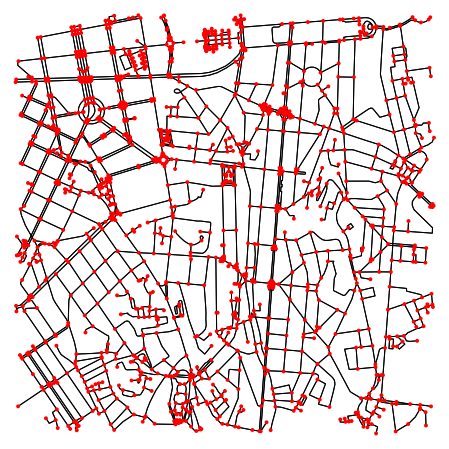

<Figure size 432x288 with 0 Axes>

In [52]:
# download the street network
G = ox.graph_from_point(location, network_type=network_type)

fig, ax = ox.plot_graph(G, bgcolor='w', node_color='r', edge_color='k');
plt.tight_layout()
plt.show()

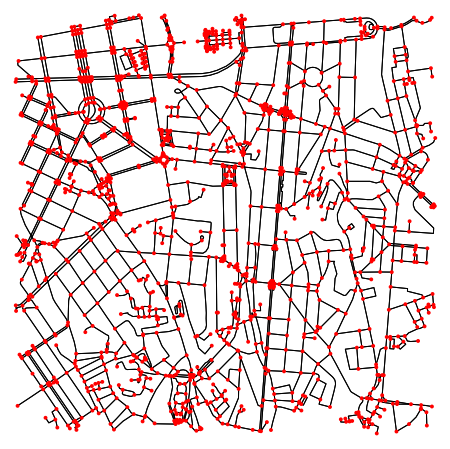

<Figure size 432x288 with 0 Axes>

In [53]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

fig, ax = ox.plot_graph(G, bgcolor='w', node_color='r', edge_color='k');
plt.tight_layout()
plt.show()

In [ ]:
ox.add_edge_travel_times(ox.add_edge_speeds(G, hwy_speeds={'residentia5l': 50}, fallback=4.5)).edges(data=True)

In [60]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
# meters_per_minute = travel_speed * 1000 / 3600 #km per hour to m per second
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [ ]:
G.edges(data=True, keys=True)

# Save file as geojson

# G = ox.graph_from_place('Piedmont, CA, USA', network_type='drive')

# # save graph nodes and edges to disk as GeoJSON
# gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
# gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
# gdf_nodes.to_file('nodes.geojson', driver='GeoJSON')
# gdf_edges.to_file('edges.geojson', driver='GeoJSON')

# #-------------------------------------------------------------------------------

# G = ox.graph_from_place('Piedmont, CA, USA', network_type='drive')
# ox.save_graph_shapefile(G, filepath='./shapefile/', directed=True)

# # load shapefiles of nodes and directed edges as a graph
# gdf_nodes = gpd.read_file('./shapefile/nodes.shp').set_index('osmid')
# gdf_edges = gpd.read_file('./shapefile/edges.shp').set_index(['u', 'v', 'key'])
# G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

In [28]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='jet', start=0, return_hex=True)
iso_colors

['#000080', '#0080ff', '#7dff7a', '#ff9400', '#800000']

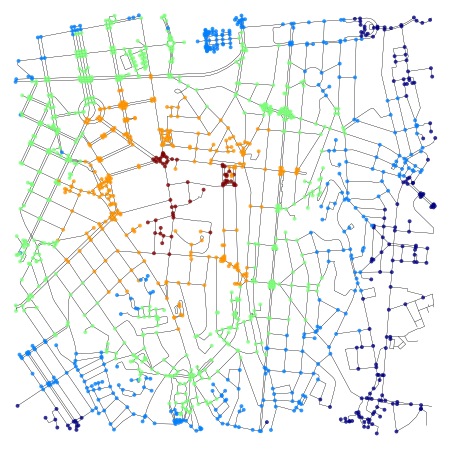

In [27]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]

ns = [15 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2, bgcolor='w', edge_linewidth=0.2, edge_color='k')

In [63]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

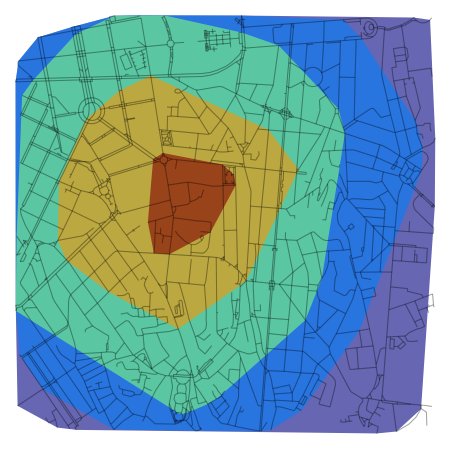

In [68]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', 
                        edge_alpha=0.2, node_size=0, bgcolor='w')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

plt.show()

In [81]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)

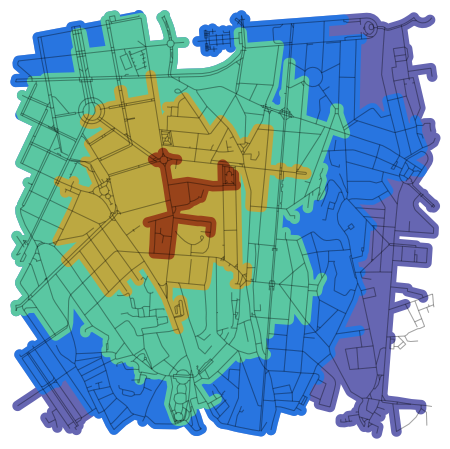

In [82]:
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k',
                        edge_alpha=0.2, node_size=0, bgcolor='w')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

plt.show()

In [19]:
isochrone_polys[0].exterior.coords[0]

(488210.94703946676, 4285689.599560294)